# Micro CT Dual Energy Decomposition

This is a very basic script to perform a monoenergetic material decomposition according to
Alvarez, Robert E., and Albert Macovski. "Energy-selective reconstructions in x-ray computerised tomography." Physics in Medicine & Biology 21.5 (1976): 733.
You will have to load the images and enter a few values, which you can get from the scan logs or databases.
If you have any question please contact your tutor.
Before you start with this part we need to get the mean energy of the used spectra. For this you can use the skript "MeanEnergySpectrum"


First, install one more package which is convenient to select regions-of-interest (ROI), after installation, please restart the kernel.

------

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time, sys, pickle
import scipy
import scipy.ndimage as nd
from PIL import Image
import xraylib
import roipoly
%matplotlib inline

## Step 1: Loading the images and correcting them.

The reconstructed images are saved as 16 bit tif files. This means they contain integer values between 0 and 65535. 
During reconstruction the attenuation coefficient mu is reconstructed and then mapped to the tif values. 
You can find the minimum and maximum value in the ..._rec.txt file as 'min = ' and 'max = '

In order to load the tif file we use pillow (or PIL Python Image Library). Directly convert them to a numpy array.
LE is labeling the low energetic spectrum image, HE the high energetic spectrum image.

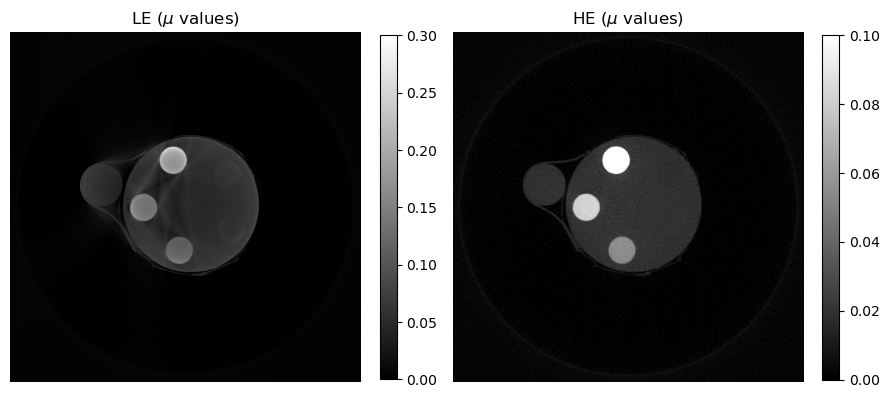

In [61]:
LE=np.array(Image.open(r'LE_reco_slice_0700.tif')) # file name of low energy images
HE=np.array(Image.open(r'HE_reco_slice_0700.tif')) # file name of high energy images

# Enter the values from the reconstruction txt files here
LE_min = -0.22631276
LE_max = 0.62555987

HE_min = -0.25967914
HE_max = 0.6672639

def tif_to_mu(img, w_min, w_max):
    '''
    Just a small function to recover the mu values in 1/cm.
    '''
    a = (w_max - w_min)/65535.
    return (img * a + w_min)

# convert the tif scaled images into mu scaled images
LE_mu = tif_to_mu(LE, LE_min, LE_max)
HE_mu = tif_to_mu(HE, HE_min, HE_max)

# checking out the mu images
plt.figure(figsize = (9, 4))
plt.subplot(121)
plt.imshow(LE_mu, cmap='gray', vmin = 0, vmax = 0.3) # please tune vmin, vmax values for better visualization 
plt.colorbar(fraction=0.0445, pad=0.05)
plt.title(r'LE ($\mu$ values)')
plt.axis('off')

plt.subplot(122)
plt.imshow(HE_mu, cmap='gray', vmin = 0, vmax = 0.1) # please tune vmin, vmax values for better visualization 
plt.colorbar(fraction=0.0445, pad=0.05)
plt.title(r'HE ($\mu$ values)')
plt.axis('off')
plt.tight_layout()
plt.savefig(r'./report_figures/LE_and_HE_images.pdf')

## Step 2: Build the coefficient matrix for the material decomp.

Here we need the mass absorption coefficients at the low and the high energy value, as well as the mass density you can use the xcom database from the NIST to look this up. https://www.nist.gov/pml/x-ray-mass-attenuation-coefficients

In [62]:
E_LE = 27.94 # keV, mean energy of LE spectrum of x-ray tube
E_HE = 58.49 # keV,  mean energy of HE spectrum of x-ray tube

material_1 = "KI" # chemical formula for material 1, e.g., 'CaCO3'
mu_1_LE = xraylib.CS_Total_CP(material_1, E_LE)
mu_1_HE = xraylib.CS_Total_CP(material_1, E_HE)
print('The attenuation of %s at %s keV is %s cm2/g'%(material_1, E_LE, mu_1_LE))
print('The attenuation of %s at %s keV is %s cm2/g \n'%(material_1, E_HE, mu_1_HE))

material_2 = "H2O" # chemical formula for material 2, e.g., 'H2O'
mu_2_LE = xraylib.CS_Total_CP(material_2, E_LE) # NaCl
mu_2_HE = xraylib.CS_Total_CP(material_2, E_HE) 
print('The attenuation of %s at %s keV is %s cm2/g'%(material_2, E_LE, mu_2_LE))
print('The attenuation of %s at %s keV is %s cm2/g \n'%(material_2, E_HE, mu_2_HE))


# As we are performing a two material decomposition, the coeff matrix is 2x2
coeff = np.array([[mu_1_LE, mu_2_LE],[mu_1_HE, mu_2_HE]])
print('coefficient matrix is: \n',coeff)

The attenuation of KI at 27.94 keV is 8.891188368422853 cm2/g
The attenuation of KI at 58.49 keV is 6.342968698275308 cm2/g 

The attenuation of H2O at 27.94 keV is 0.418971180790213 cm2/g
The attenuation of H2O at 58.49 keV is 0.20840249735130628 cm2/g 

coefficient matrix is: 
 [[8.89118837 0.41897118]
 [6.3429687  0.2084025 ]]


## Step 3: Performing the decomposition

You need to solve the LSE for each pixel. You can do so by iterating over every pixel, or make use of numpy.
Iterating is a lot slower, so we will use the numpy way.
For this, we need to bring our data in the right shape: one array, where the last axis is the low or high energy pixel value.

In [63]:
measurements = np.zeros((HE_mu.shape[0],HE_mu.shape[1],2)) # build an empty array in the right shape
measurements[:,:, 0] = LE_mu[:HE_mu.shape[0],:HE_mu.shape[1]] # assign the images to the last axis
measurements[:,:, 1] = HE_mu[:HE_mu.shape[0],:HE_mu.shape[1]]

# This is the step where all the numpy magic happens. 
# If you want to understand the notation, please look at the numpy documentation and make yourself familiar with its array broadcasting rules.
decomp=np.linalg.solve(coeff[None, None], measurements)

# its easier to look at the images individually.
decomp_mat_1 = decomp[:,:,0]
decomp_mat_2 = decomp[:,:,1]

## Step 4: Simple image processing to better display the image

We want a better view of the images, which can be obtained by an image cropping and image rotation.

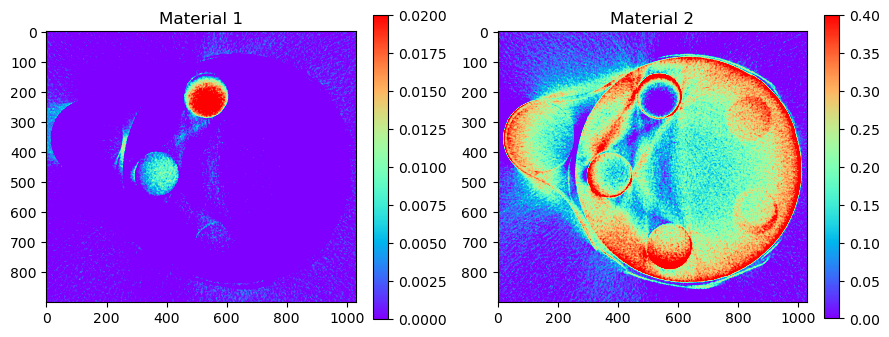

In [64]:
rotation_angle = 0
cropping_range = np.s_[500:1400, 370:1400] # crop images, for example: np.s_[200:800, 200:800]

# please change here the zoom in regions, and rotation angles
zoom_decomp_mat_1 = nd.rotate(decomp_mat_1[cropping_range], rotation_angle, reshape = False)
zoom_decomp_mat_2 = nd.rotate(decomp_mat_2[cropping_range], rotation_angle, reshape = False)

# Figure without ROIs for report
plt.figure(figsize = (9, 4))
plt.subplot(121)
plt.imshow(zoom_decomp_mat_1, cmap = 'rainbow', vmin = 0, vmax=0.02) # tune vmax number to better visualize images
plt.colorbar(fraction=0.0445, pad=0.05)
plt.title('Material 1')
plt.subplot(122)
plt.imshow(zoom_decomp_mat_2, cmap = 'rainbow', vmin = 0, vmax=0.4) # tune vmax number to better visualize images
plt.colorbar(fraction=0.0445, pad=0.05)
plt.title('Material 2')
plt.tight_layout()

## Step 5: quantitave mean values in selected regions-of-interest (ROI)
Finally, we want to know the quantitative values in different ROIs.<br />
Left click to select ROI, after difining the ROI, right click to save ROI.<br />
Then comment (#) the selected ROI so that rerunning the code does not initialize the ROI values selected before.<br />

The same procedure is repeated for other ROIs.<br />

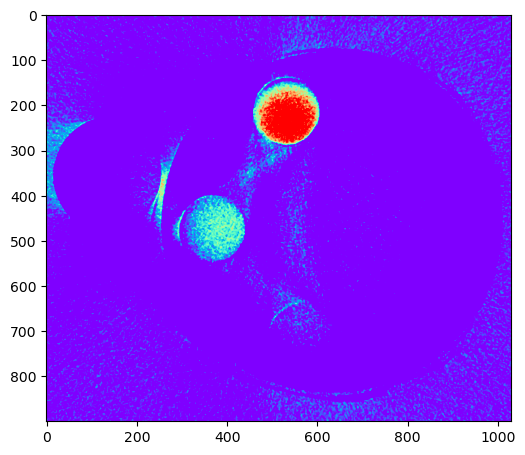

In [65]:
ROI_1 = np.s_[975-500:1025-500, 975-370:1025-370] #np.s_[500:1400, 370:1400]
ROI_2 = np.s_[825-500:875-500, 475-370:525-370]
ROI_3 = np.s_[700-500:750-500, 850-370:900-370]
ROI_4 = np.s_[975-500:1025-500, 725-370:775-370]
ROI_5 = np.s_[1200-500:1250-500, 900-370:950-370]
ROI_6 = np.s_[1100-500:1150-500, 1200-370:1250-370]
ROI_7 = np.s_[800-500:850-500, 1200-370:1250-370]

roi_1 = [975-500, 1025-500, 975-370,1025-370]
roi_2 = [825-500, 875-500, 475-370, 525-370]
roi_3 = [700-500,750-500, 850-370,900-370]
roi_4 = [975-500,1025-500, 725-370,775-370]
roi_5 = [1200-500,1250-500, 900-370,950-370]
roi_6 = [1100-500,1150-500, 1200-370,1250-370]
roi_7 = [800-500,850-500, 1200-370,1250-370]

plt.figure(figsize = (6,6))
plt.imshow(zoom_decomp_mat_1, cmap = 'rainbow', vmin = 0, vmax = 0.02) # you can change vmin, vmax values for better visualization

Material 1 KI roi 1 : -2.470 mg/mL
Material 1 KI roi 2 : -3.804 mg/mL
Material 1 KI roi 3 : 21.128 mg/mL
Material 1 KI roi 4 : 7.744 mg/mL
Material 1 KI roi 5 : -1.602 mg/mL
Material 1 KI roi 6 : -5.199 mg/mL
Material 1 KI roi 7 : -6.471 mg/mL
Material 2 H2O roi 1 : 169.959 mg/mL
Material 2 H2O roi 2 : 210.820 mg/mL
Material 2 H2O roi 3 : -16.333 mg/mL
Material 2 H2O roi 4 : 160.687 mg/mL
Material 2 H2O roi 5 : 313.532 mg/mL
Material 2 H2O roi 6 : 251.780 mg/mL
Material 2 H2O roi 7 : 285.421 mg/mL


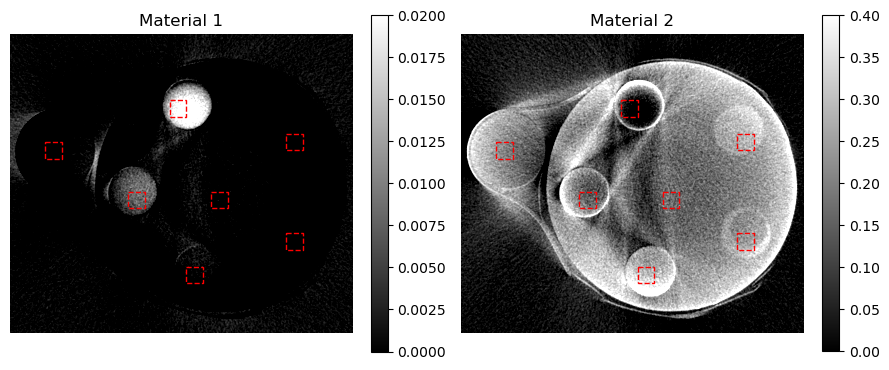

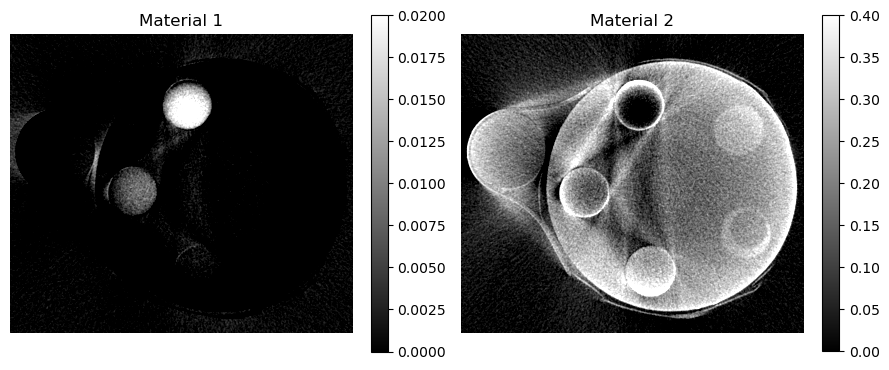

In [79]:
roi_all = [roi_1, roi_2, roi_3, roi_4, roi_5, roi_6, roi_7] # put all rois in the list
ROI_all = [ROI_1, ROI_2, ROI_3, ROI_4, ROI_5, ROI_6, ROI_7]
cmap = 'gray' # or other colormaps for plotting (check out on matplotlib website)

# Figure with ROIs for report
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))
plt.subplot(121)
im = ax1.imshow(zoom_decomp_mat_1, cmap = cmap, vmin = 0, vmax=0.02)
plt.colorbar(im, ax=ax1, fraction=0.0445, pad=0.05)

for i, roi_i in enumerate(roi_all):
    rect = patches.Rectangle((roi_i[2], roi_i[0]), roi_i[3]-roi_i[2], roi_i[1]-roi_i[0], linewidth=1, edgecolor='r', facecolor='none', linestyle="--")
    ax1.add_patch(rect)
    print('Material 1 %s roi %d : %.3f mg/mL'%(material_1, (i+1), np.mean(zoom_decomp_mat_1[ROI_all[i]]) * 1000))

plt.title('Material 1')
plt.axis('off')

plt.subplot(122)
im2 = ax2.imshow(zoom_decomp_mat_2, cmap = cmap, vmin = 0, vmax=0.4)
plt.colorbar(im2, ax=ax2, fraction=0.0445, pad=0.05)
plt.title('Material 2')
plt.axis('off')
for i, roi_i in enumerate(roi_all):
    rect = patches.Rectangle((roi_i[2], roi_i[0]), roi_i[3]-roi_i[2], roi_i[1]-roi_i[0], linewidth=1, edgecolor='r', facecolor='none', linestyle="--")
    ax2.add_patch(rect)
    print('Material 2 %s roi %d : %.3f mg/mL'%(material_2, (i+1), np.mean(zoom_decomp_mat_2[ROI_all[i]]) * 1000))
plt.tight_layout()
plt.savefig(r'./report_figures/dual_energy_decomp_with_ROIs.pdf')
# Figure without ROIs for report

plt.figure(figsize = (9, 4))
plt.subplot(121)
plt.imshow(zoom_decomp_mat_1, cmap = cmap, vmin = 0, vmax=0.02)
plt.colorbar(fraction=0.0445, pad=0.05)
plt.axis('off')
plt.title('Material 1')
plt.subplot(122)
plt.imshow(zoom_decomp_mat_2, cmap = cmap, vmin = 0, vmax=0.4)
plt.colorbar(fraction=0.0445, pad=0.05)
plt.axis('off')
plt.title('Material 2')
plt.tight_layout()
plt.savefig(r'./report_figures/dual_energy_decomp_without_ROIs.pdf')